(eb)=

# Fitting a detached eclipsing binary

In [1]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

exoplanet.__version__ = '0.5.1.dev17+g7064fb0'


In this case study, we'll go through the steps required to fit the light curve and radial velocity measurements for the detached eclipsing binary system HD 23642.
This is a bright system that has been fit by many authors ([1](https://arxiv.org/abs/astro-ph/0403444), [2](https://arxiv.org/abs/astro-ph/0409507), [3](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract), [4](https://arxiv.org/abs/1602.01901), and [5](https://arxiv.org/abs/1603.08484) to name a few) so this is a good benchmark for our demonstration.

The light curve that we'll use is from K2 and we'll use the same radial velocity measurements as [David+ (2016)](https://arxiv.org/abs/1602.01901) compiled from [here](https://arxiv.org/abs/astro-ph/0403444) and [here](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract).
We'll use a somewhat simplified model for the eclipses that treats the stars as spherical and ignores the phase curve (we'll model it using a Gaussian process instead of a more physically motivated model).
But, as you'll see, these simplifying assumptions are sufficient for this case of a detached and well behaved system.
Unlike some previous studies, we will fit an eccentric orbit instead of fixing the eccentricity to zero.
This probably isn't really necessary here, but it's useful to demonstrate how you would fit a more eccentric system.
Finally, we model the phase curve and other triends in both the light curve and radial velocities using Gaussian processes.
This will account for unmodeled stellar variability and residual systematics, drifts, and other effects left over from the data reduction procedure.

## Data access

First, let's define some values from the literature that will be useful below.
Here we're taking the period and eclipse time from [David+ (2016)](https://arxiv.org/abs/1602.01901) as initial guesses for these parameters in our fit.
We'll also include the same prior on the flux ratio of the two stars that was computed for the Kepler bandpass by [David+ (2016)](https://arxiv.org/abs/1602.01901).

In [2]:
lit_period = 2.46113408
lit_t0 = 119.522070 + 2457000 - 2454833

# Prior on the flux ratio for Kepler
lit_flux_ratio = (0.354, 0.035)

Then we'll download the Kepler data.
In this case, the pipeline aperture photometry isn't very good (because this star is so bright!) so we'll just download the target pixel file and co-add all the pixels.

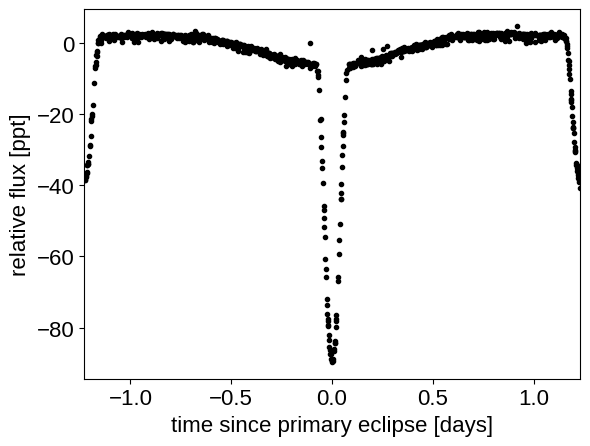

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("EPIC 211082420").download()
lc = tpf.to_lightcurve(aperture_mask="all")
lc = lc.remove_nans().normalize()

hdr = tpf.hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# To keep things fast for this example, we're only going to use a third of the data
np.random.seed(68594)
m = np.random.rand(len(lc.time)) < 1.0 / 3

x = np.ascontiguousarray(lc.time.value[m], dtype=np.float64)
y = np.ascontiguousarray(lc.flux[m], dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

plt.plot(
    (x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period, y, ".k"
)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.xlabel("time since primary eclipse [days]")
_ = plt.ylabel("relative flux [ppt]")

Then we'll enter the radial velocity data.
I couldn't find these data online anywhere so I manually transcribed the data from the referenced papers (typos are my own!).

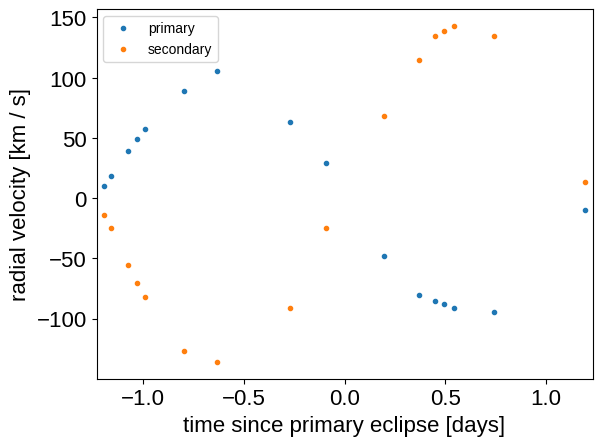

In [4]:
ref1 = 2453000
ref2 = 2400000
rvs = np.array(
    [
        # https://arxiv.org/abs/astro-ph/0403444
        (39.41273 + ref1, -85.0, 134.5),
        (39.45356 + ref1, -88.0, 139.0),
        (39.50548 + ref1, -91.0, 143.0),
        (43.25049 + ref1, 105.5, -136.0),
        (46.25318 + ref1, 29.5, -24.5),
        # https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract
        (52629.6190 + ref2, 88.8, -127.0),
        (52630.6098 + ref2, -48.0, 68.0),
        (52631.6089 + ref2, -9.5, 13.1),
        (52632.6024 + ref2, 63.6, -90.9),
        (52633.6162 + ref2, -94.5, 135.0),
        (52636.6055 + ref2, 10.3, -13.9),
        (52983.6570 + ref2, 18.1, -25.1),
        (52987.6453 + ref2, -80.6, 114.5),
        (52993.6322 + ref2, 49.0, -70.7),
        (53224.9338 + ref2, 39.0, -55.7),
        (53229.9384 + ref2, 57.2, -82.0),
    ]
)
rvs[:, 0] -= 2454833
rvs = rvs[np.argsort(rvs[:, 0])]

x_rv = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
y1_rv = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
y2_rv = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

fold = (rvs[:, 0] - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
plt.plot(fold, rvs[:, 1], ".", label="primary")
plt.plot(fold, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

## Probabilistic model

Then we define the probabilistic model using PyMC3 and exoplanet.
This is similar to the other tutorials and case studies, but here we're using a [SecondaryEclipseLightCurve](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.SecondaryEclipseLightCurve) to generate the model light curve and we're modeling the radial velocity trends using a Gaussian process instead of a polynomial.
Otherwise, things should look pretty familiar!

After defining the model, we iteratively clip outliers in the light curve using sigma clipping and then estimate the maximum a posteriori parameters.

In [5]:
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import exoplanet as xo
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess


def build_model(mask):

    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=5.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        log_M1 = pm.Normal("log_M1", mu=0.0, sigma=10.0)
        log_R1 = pm.Normal("log_R1", mu=0.0, sigma=10.0)
        M1 = pm.Deterministic("M1", tt.exp(log_M1))
        R1 = pm.Deterministic("R1", tt.exp(log_R1))

        # Secondary ratios
        log_k = pm.Normal("log_k", mu=0.0, sigma=10.0)  # radius ratio
        log_q = pm.Normal("log_q", mu=0.0, sigma=10.0)  # mass ratio
        log_s = pm.Normal(
            "log_s", mu=np.log(0.5), sigma=10.0
        )  # surface brightness ratio
        pm.Deterministic("k", tt.exp(log_k))
        pm.Deterministic("q", tt.exp(log_q))
        pm.Deterministic("s", tt.exp(log_s))

        # Prior on flux ratio
        pm.Normal(
            "flux_prior",
            mu=lit_flux_ratio[0],
            sigma=lit_flux_ratio[1],
            observed=tt.exp(2 * log_k + log_s),
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=tt.exp(log_k), testval=1.5)
        log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=1.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = pmx.UnitDisk("ecs", testval=np.array([1e-5, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", tt.exp(log_k + log_R1))
        M2 = pm.Deterministic("M2", tt.exp(log_q + log_M1))
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval=1.0,
            **pmx.estimate_inverse_gamma_parameters(0.1, 2.0),
        )
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval=0.5,
            **pmx.estimate_inverse_gamma_parameters(1.0, 5.0),
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval=5.0,
            **pmx.estimate_inverse_gamma_parameters(1.0, 5.0),
        )
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3)

        # Noise model for the radial velocities
        sigma_rv1 = pm.InverseGamma(
            "sigma_rv1",
            testval=1.0,
            **pmx.estimate_inverse_gamma_parameters(0.5, 5.0),
        )
        sigma_rv2 = pm.InverseGamma(
            "sigma_rv2",
            testval=1.0,
            **pmx.estimate_inverse_gamma_parameters(0.5, 5.0),
        )
        sigma_rv_gp = pm.InverseGamma(
            "sigma_rv_gp",
            testval=1.5,
            **pmx.estimate_inverse_gamma_parameters(1.0, 5.0),
        )
        rho_rv_gp = pm.InverseGamma(
            "rho_rv_gp",
            testval=2.0,
            **pmx.estimate_inverse_gamma_parameters(1.0, 25.0),
        )
        kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, tt.exp(log_s))

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:, 0]
            )

        # Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))

        # Set up the radial velocity model
        def model_rv1(t):
            return mean_rv + 1e-3 * orbit.get_radial_velocity(t)

        def model_rv2(t):
            return mean_rv - 1e-3 * orbit.get_radial_velocity(t) * tt.exp(
                -log_q
            )

        # Condition the radial velocity model on the data
        gp_rv1 = GaussianProcess(kernel_rv, t=x_rv, yerr=sigma_rv1)
        gp_rv1.marginal("obs_rv1", observed=y1_rv - model_rv1(x_rv))
        gp_rv2 = GaussianProcess(kernel_rv, t=x_rv, yerr=sigma_rv2)
        gp_rv2.marginal("obs_rv2", observed=y2_rv - model_rv2(x_rv))

        # Optimize the logp
        map_soln = model.test_point

        # First the RV parameters
        map_soln = pmx.optimize(map_soln, [mean_rv, log_q])
        map_soln = pmx.optimize(
            map_soln, [mean_rv, sigma_rv1, sigma_rv2, sigma_rv_gp, rho_rv_gp]
        )

        # Then the LC parameters
        map_soln = pmx.optimize(map_soln, [mean_lc, log_R1, log_k, log_s, b])
        map_soln = pmx.optimize(
            map_soln, [mean_lc, log_R1, log_k, log_s, b, u1, u2]
        )
        map_soln = pmx.optimize(
            map_soln, [mean_lc, sigma_lc, sigma_gp, rho_gp]
        )
        map_soln = pmx.optimize(map_soln, [t0, log_period])

        # Then all the parameters together
        map_soln = pmx.optimize(map_soln, [mean_rv, log_q, ecs])
        map_soln = pmx.optimize(map_soln)

        extras = dict(
            x=x[mask],
            y=y[mask],
            model_lc=model_lc,
            model_rv1=model_rv1,
            model_rv2=model_rv2,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
        )

    return model, map_soln, extras


def sigma_clip():
    mask = np.ones(len(x), dtype=bool)
    num = len(mask)

    for i in range(10):
        model, map_soln, extras = build_model(mask)

        with model:
            mdl = pmx.eval_in_model(
                extras["model_lc"](extras["x"]) + extras["gp_lc_pred"],
                map_soln,
            )

        resid = y[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
        mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
        print("Sigma clipped {0} light curve points".format(num - mask.sum()))
        if num - mask.sum() < 10:
            break
        num = mask.sum()

    return model, map_soln, extras


model, map_soln, extras = sigma_clip()

optimizing logp for variables: [log_q, mean_rv]


message: Optimization terminated successfully.
logp: -17975.19056073329 -> -13061.232126554985


optimizing logp for variables: [rho_rv_gp, sigma_rv_gp, sigma_rv2, sigma_rv1, mean_rv]


message: Optimization terminated successfully.
logp: -13061.232126554985 -> -9681.173599912336


optimizing logp for variables: [b, log_k, log_s, log_R1, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -9681.173599912336 -> nan
final logp not finite, returning initial point


this suggests that something is wrong with the model


optimizing logp for variables: [u2, u1, b, log_k, log_s, log_R1, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -9681.173599912336 -> nan
final logp not finite, returning initial point


this suggests that something is wrong with the model


optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -9681.173599912336 -> -2782.0945356823463


optimizing logp for variables: [log_period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -2782.0945356823463 -> -2780.933505245464


optimizing logp for variables: [ecs, log_q, mean_rv]


message: Optimization terminated successfully.
logp: -2780.933505245464 -> -2428.8731521050895


optimizing logp for variables: [rho_rv_gp, sigma_rv_gp, sigma_rv2, sigma_rv1, rho_gp, sigma_gp, sigma_lc, ecs, t0, log_period, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -2428.8731521050895 -> -1215.943657758813


Sigma clipped 12 light curve points


optimizing logp for variables: [log_q, mean_rv]


message: Optimization terminated successfully.
logp: -17888.051068837613 -> -12970.771444043476


optimizing logp for variables: [rho_rv_gp, sigma_rv_gp, sigma_rv2, sigma_rv1, mean_rv]


message: Optimization terminated successfully.
logp: -12970.771444043476 -> -9589.122125143409


optimizing logp for variables: [b, log_k, log_s, log_R1, mean_lc]


message: Optimization terminated successfully.
logp: -9589.122125143409 -> -4316.483140637536


optimizing logp for variables: [u2, u1, b, log_k, log_s, log_R1, mean_lc]


message: Optimization terminated successfully.
logp: -4316.483140637536 -> -4227.609496198706


optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc, mean_lc]


message: Optimization terminated successfully.
logp: -4227.609496198706 -> -1858.9804383877795


optimizing logp for variables: [log_period, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -1858.9804383877795 -> -1854.6790040504793


optimizing logp for variables: [ecs, log_q, mean_rv]


message: Optimization terminated successfully.
logp: -1854.6790040504793 -> -1734.0986568029691


optimizing logp for variables: [rho_rv_gp, sigma_rv_gp, sigma_rv2, sigma_rv1, rho_gp, sigma_gp, sigma_lc, ecs, t0, log_period, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -1734.0986568029691 -> -1032.402630582228


Sigma clipped 0 light curve points


At these maximum a posteriori parameters, let's make some plots of the model predictions compared to the observations to make sure that things look reasonable.
First the phase-folded radial velocities:

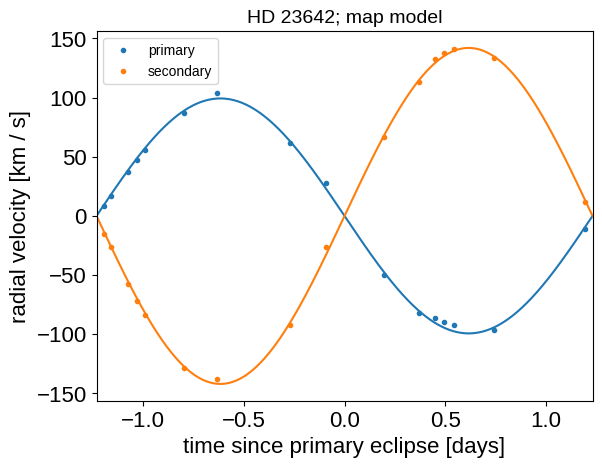

In [6]:
period = map_soln["period"]
t0 = map_soln["t0"]
mean = map_soln["mean_rv"]

x_fold = (x_rv - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(fold, y1_rv - mean, ".", label="primary")
plt.plot(fold, y2_rv - mean, ".", label="secondary")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
with model:
    y1_mod, y2_mod = pmx.eval_in_model(
        [extras["model_rv1"](x_phase + t0), extras["model_rv2"](x_phase + t0)],
        map_soln,
    )
plt.plot(x_phase, y1_mod - mean, "C0")
plt.plot(x_phase, y2_mod - mean, "C1")

plt.legend(fontsize=10)
plt.xlim(-0.5 * period, 0.5 * period)
plt.ylabel("radial velocity [km / s]")
plt.xlabel("time since primary eclipse [days]")
_ = plt.title("HD 23642; map model", fontsize=14)

And then the light curve.
In the top panel, we show the Gaussian process model for the phase curve.
It's clear that there's a lot of information there that we could take advantage of, but that's a topic for another day.
In the bottom panel, we're plotting the phase folded light curve and we can see the ridiculous signal to noise that we're getting on the eclipses.

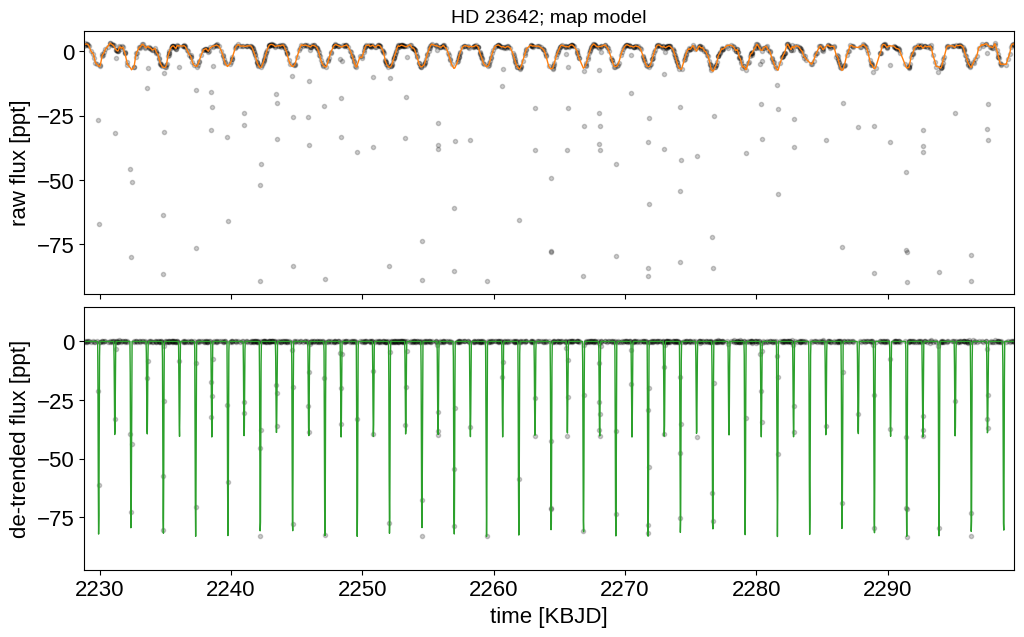

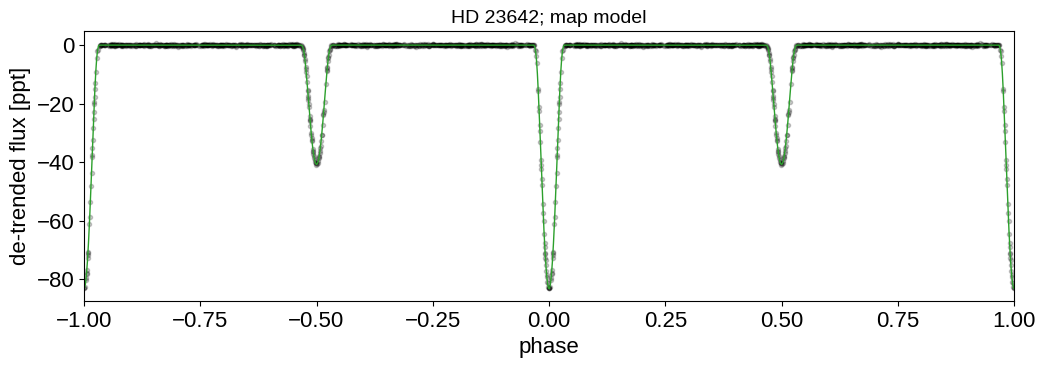

In [7]:
t_lc_pred = np.linspace(x.min(), x.max(), 3000)
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln) + map_soln["mean_lc"]
    )
    lc = (
        pmx.eval_in_model(extras["model_lc"](t_lc_pred), map_soln)
        - map_soln["mean_lc"]
    )

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

ax1.plot(extras["x"], extras["y"], "k.", alpha=0.2)
ax1.plot(extras["x"], gp_pred, color="C1", lw=1)

ax2.plot(extras["x"], extras["y"] - gp_pred, "k.", alpha=0.2)
ax2.plot(t_lc_pred, lc, color="C2", lw=1)
ax2.set_xlim(extras["x"].min(), extras["x"].max())

ax1.set_ylabel("raw flux [ppt]")
ax2.set_ylabel("de-trended flux [ppt]")
ax2.set_xlabel("time [KBJD]")
ax1.set_title("HD 23642; map model", fontsize=14)

fig.subplots_adjust(hspace=0.05)

fig, ax1 = plt.subplots(1, figsize=(12, 3.5))

x_fold = (
    (extras["x"] - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
)
inds = np.argsort(x_fold)

ax1.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
ax1.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
ax2.plot(
    x_fold[inds],
    extras["y"][inds] - gp_pred[inds],
    "k.",
    alpha=0.2,
    label="data!",
)
ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

yval = extras["y"][inds] - gp_pred
bins = np.linspace(0, 1, 75)
num, _ = np.histogram(x_fold[inds], bins, weights=yval)
denom, _ = np.histogram(x_fold[inds], bins)
ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

args = dict(lw=1)

x_fold = (t_lc_pred - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
inds = np.argsort(x_fold)
ax1.plot(x_fold[inds], lc[inds], "C2", **args)
ax1.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

ax1.set_xlim(-1, 1)
ax1.set_ylabel("de-trended flux [ppt]")
ax1.set_xlabel("phase")
_ = ax1.set_title("HD 23642; map model", fontsize=14)

## Sampling

Finally we can run the MCMC:

In [8]:
np.random.seed(23642)
with model:
    trace = pmx.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [rho_rv_gp, sigma_rv_gp, sigma_rv2, sigma_rv1, rho_gp, sigma_gp, sigma_lc, ecs, t0, log_period, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 355 seconds.


The number of effective samples is smaller than 25% for some parameters.


As usual, we can check the convergence diagnostics for some of the key parameters.

In [9]:
import arviz as az

az.summary(trace, var_names=["M1", "M2", "R1", "R2", "ecs", "incl", "s"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M1,2.243,0.032,2.180,2.300,0.001,0.001,1843.0,1303.0,1.0
M2,1.569,0.025,1.517,1.614,0.001,0.000,1779.0,1102.0,1.0
R1,1.761,0.034,1.703,1.832,0.001,0.001,1014.0,937.0,1.0
R2,1.504,0.052,1.406,1.600,0.002,0.001,1037.0,628.0,1.0
ecs[0],0.000,0.000,-0.000,0.000,0.000,0.000,2534.0,1563.0,1.0
ecs[1],-0.001,0.006,-0.010,0.010,0.000,0.000,2138.0,1639.0,1.0
incl,1.365,0.002,1.361,1.370,0.000,0.000,1064.0,776.0,1.0
s,0.479,0.025,0.437,0.528,0.001,0.000,1757.0,1392.0,1.0


## Results

It can be useful to take a look at some diagnostic corner plots to see how the sampling went.
First, let's look at some observables:

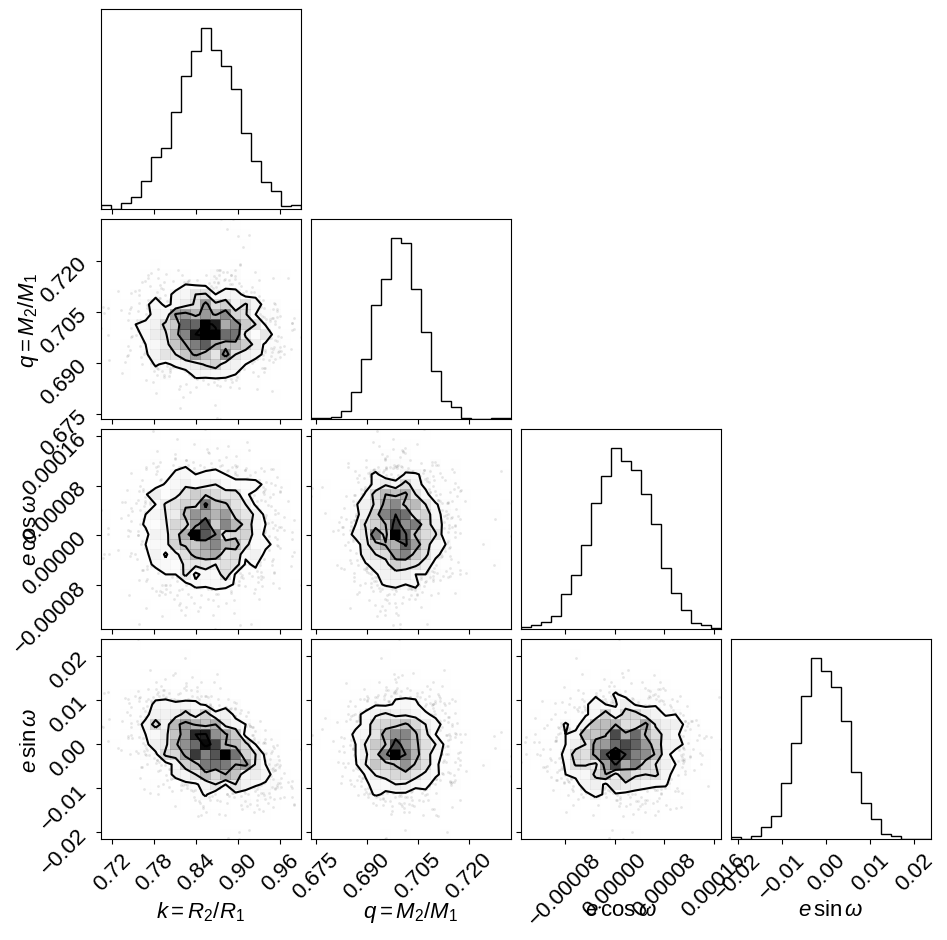

In [10]:
import corner

_ = corner.corner(
    trace,
    var_names=["k", "q", "ecs"],
    labels=[
        "$k = R_2 / R_1$",
        "$q = M_2 / M_1$",
        "$e\,\cos\omega$",
        "$e\,\sin\omega$",
    ],
)

And then we can look at the physical properties of the stars in the system.
In this figure, we're comparing to the results from [David+ (2016)](https://arxiv.org/abs/1602.01901) (shown as blue crosshairs).
The orange contours in this figure show the results transformed to a uniform prior on eccentricity as discussed below.
These contours are provided to demonstrate (qualitatively) that these inferences are not sensitive to the choice of prior.

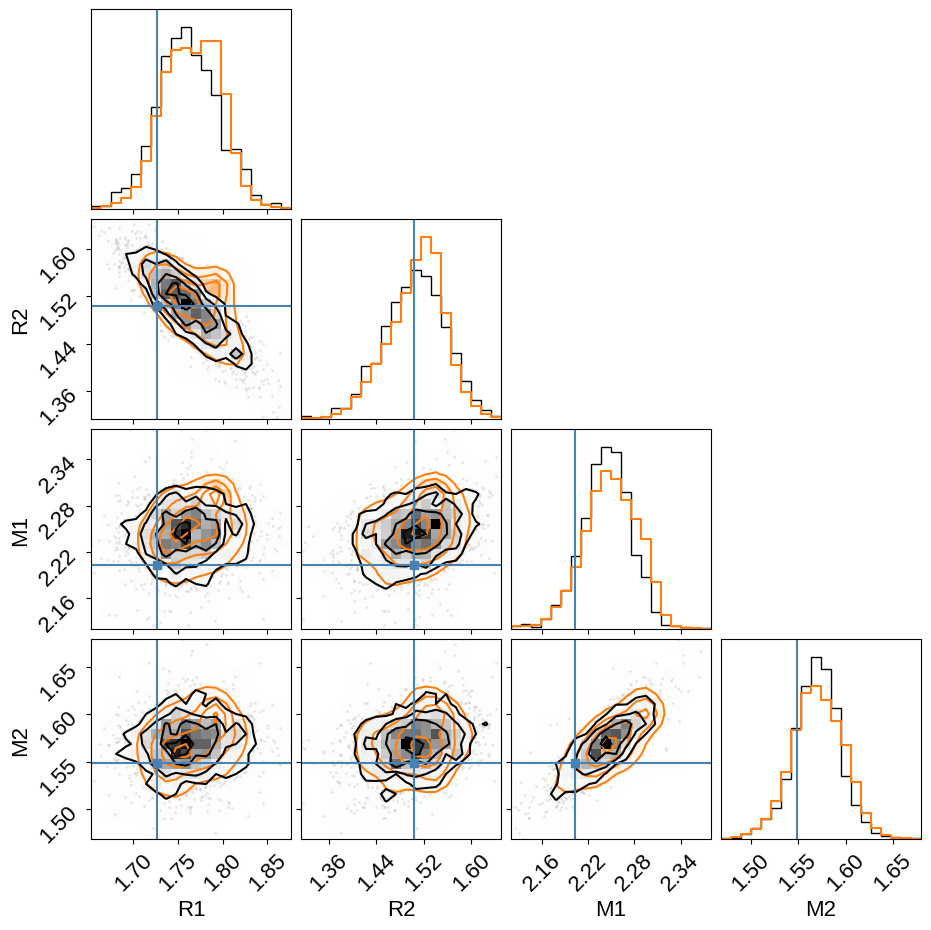

In [11]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))
weights = 1.0 / flat_samps["ecc"].values
weights *= len(weights) / np.sum(weights)
fig = corner.corner(
    trace,
    var_names=["R1", "R2", "M1", "M2"],
    weights=weights,
    plot_datapoints=False,
    color="C1",
    smooth=1,
    smooth1d=1,
)
_ = corner.corner(
    trace,
    var_names=["R1", "R2", "M1", "M2"],
    truths=[1.727, 1.503, 2.203, 1.5488],
    fig=fig,
)

## A note about eccentricities

If you looked closely at the model defined above, you might have noticed that we chose a slightly odd eccentricity prior: $p(e) \propto e$.
This is implied by sampling with $e\,\cos\omega$ and $e\,\sin\omega$ as the parameters, as has been discussed many times in the literature.
There are many options for correcting for this prior and instead assuming a uniform prior on eccentricity (for example, sampling with $\sqrt{e}\,\cos\omega$ and $\sqrt{e}\,\sin\omega$ as the parameters), but you'll find much worse sampling performance for this problem if you try any of these options (trust us, we tried!) because the geometry of the posterior surface becomes much less suitable for the sampling algorithm in PyMC3.
Instead, we can re-weight the samples after running the MCMC to see how the results change under the new prior.
Most of the parameter inferences are unaffected by this change (because the data are very constraining!), but the inferred eccentricity (and especially $e\,\sin\omega$) will depend on this choice.
The following plots show how these parameter inferences are affected.
Note, especially, how the shape of the $e\,\sin\omega$ density changes.

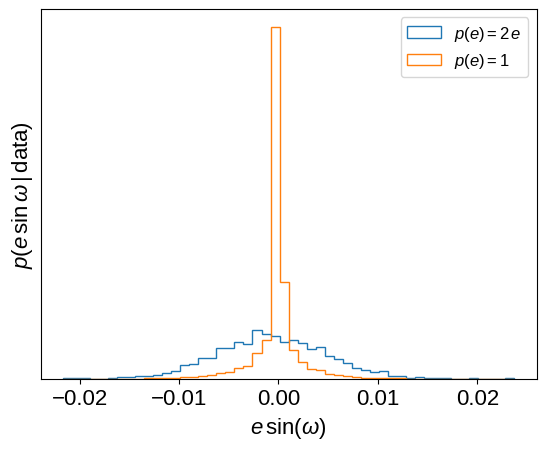

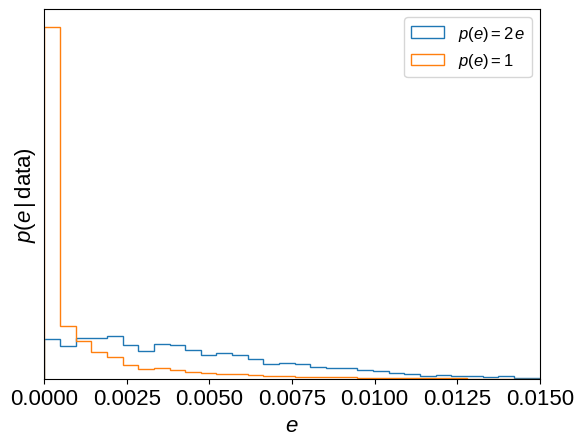

In [12]:
esinw = flat_samps["ecc"].values * np.sin(flat_samps["omega"].values)
plt.hist(
    esinw,
    50,
    density=True,
    histtype="step",
    label="$p(e) = 2\,e$",
)
plt.hist(
    esinw,
    50,
    density=True,
    histtype="step",
    weights=1.0 / flat_samps["ecc"].values,
    label="$p(e) = 1$",
)
plt.xlabel("$e\,\sin(\omega)$")
plt.ylabel("$p(e\,\sin\omega\,|\,\mathrm{data})$")
plt.yticks([])
plt.legend(fontsize=12)

plt.figure()
plt.hist(
    flat_samps["ecc"].values,
    50,
    density=True,
    histtype="step",
    label="$p(e) = 2\,e$",
)
plt.hist(
    flat_samps["ecc"].values,
    50,
    density=True,
    histtype="step",
    weights=1.0 / flat_samps["ecc"].values,
    label="$p(e) = 1$",
)
plt.xlabel("$e$")
plt.ylabel("$p(e\,|\,\mathrm{data})$")
plt.yticks([])
plt.xlim(0, 0.015)
_ = plt.legend(fontsize=12)

We can then use the `corner.quantile` function to compute summary statistics of the weighted samples as follows.
For example, here how to compute the 90% posterior upper limit for the eccentricity:

In [13]:
weights = 1.0 / flat_samps["ecc"].values
print(
    "for p(e) = 2*e: p(e < x) = 0.9 -> x = {0:.5f}".format(
        corner.quantile(flat_samps["ecc"].values, [0.9])[0]
    )
)
print(
    "for p(e) = 1:   p(e < x) = 0.9 -> x = {0:.5f}".format(
        corner.quantile(flat_samps["ecc"].values, [0.9], weights=weights)[0]
    )
)

for p(e) = 2*e: p(e < x) = 0.9 -> x = 0.00914
for p(e) = 1:   p(e < x) = 0.9 -> x = 0.00347


Or, the posterior mean and variance for the radius of the primary:

In [14]:
samples = flat_samps["R1"].values

print(
    "for p(e) = 2*e: R1 = {0:.3f} ± {1:.3f}".format(
        np.mean(samples), np.std(samples)
    )
)

mean = np.sum(weights * samples) / np.sum(weights)
sigma = np.sqrt(np.sum(weights * (samples - mean) ** 2) / np.sum(weights))
print("for p(e) = 1:   R1 = {0:.3f} ± {1:.3f}".format(mean, sigma))

for p(e) = 2*e: R1 = 1.761 ± 0.034
for p(e) = 1:   R1 = 1.766 ± 0.029


As you can see (and as one would hope) this choice of prior does not significantly change our inference of the primary radius.

## Citations

As described in the [citation tutorial](https://docs.exoplanet.codes/en/stable/tutorials/citation/), we can use [citations.get_citations_for_model](https://docs.exoplanet.codes/en/stable/user/api/#exoplanet.citations.get_citations_for_model) to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [15]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet:joss,
exoplanet:zenodo} and its dependencies \citep{celerite2:foremanmackey17,
celerite2:foremanmackey18, exoplanet:agol20, exoplanet:arviz,
exoplanet:astropy13, exoplanet:astropy18, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [16]:
print(bib.split("\n\n")[0] + "\n\n...")


@article{exoplanet:joss,
       author = {{Foreman-Mackey}, Daniel and {Luger}, Rodrigo and {Agol}, Eric
                and {Barclay}, Thomas and {Bouma}, Luke G. and {Brandt},
                Timothy D. and {Czekala}, Ian and {David}, Trevor J. and
                {Dong}, Jiayin and {Gilbert}, Emily A. and {Gordon}, Tyler A.
                and {Hedges}, Christina and {Hey}, Daniel R. and {Morris},
                Brett M. and {Price-Whelan}, Adrian M. and {Savel}, Arjun B.},
        title = "{exoplanet: Gradient-based probabilistic inference for
                  exoplanet data \& other astronomical time series}",
      journal = {arXiv e-prints},
         year = 2021,
        month = may,
          eid = {arXiv:2105.01994},
        pages = {arXiv:2105.01994},
archivePrefix = {arXiv},
       eprint = {2105.01994},
 primaryClass = {astro-ph.IM},
       adsurl = {https://ui.adsabs.harvard.edu/abs/2021arXiv210501994F},
      adsnote = {Provided by the SAO/NASA Astrophysics Data System